In [1]:
import os, pickle
from tqdm import tqdm  # Import tqdm for progress tracking
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm


## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)
    

## Plain MD

In [3]:
plain_md_path = '../Plain_MD/analysis'

omega_loaded = Data.load(f"{plain_md_path}/autocoorel_data/res_implied_timescale_clustersize_70_withnan.pkl").array_list
plain_md_pi_all_means = omega_loaded[0]
plain_md_pi_all_stds = omega_loaded[1]
plain_md_lagtimes_ns = omega_loaded[4]

plain_md_pi_all_means.shape



(3, 154, 2)

Residue 0: 201.0 ns : 0.725 ± 0.028
Residue 1: 201.0 ns : 0.473 ± 0.107
Residue 2: 201.0 ns : 0.548 ± 0.084


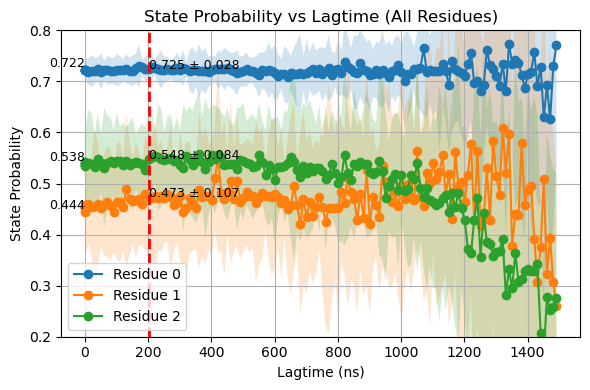

In [4]:
residues = [0, 1, 2]
dt_in_ns = 0.01  # 10 ps per step

plt.figure(figsize=(6, 4))  # One single figure

for res in residues:
    pi_means = plain_md_pi_all_means[res]
    pi_stds = plain_md_pi_all_stds[res] 

    plt.plot(plain_md_lagtimes_ns, pi_means[:, 1], '-o', label=f'Residue {res}')
    
    # Add shaded region for standard deviation
    plt.fill_between(plain_md_lagtimes_ns, 
                        pi_means[:, 1] + pi_stds[:, 1],  # Upper bound
                        pi_means[:, 1] - pi_stds[:, 1],  # Lower bound
                        alpha=0.2)

    # Annotate the first point with its value (index 0)
    first_x0 = plain_md_lagtimes_ns[0]
    first_y0 = pi_means[0, 1]
    plt.text(first_x0, first_y0, f"{first_y0:.3f}", fontsize=9, ha='right', va='bottom')

    # Annotate lagtime index 24
    first_x = plain_md_lagtimes_ns[24]
    first_y = pi_means[24, 1]
    first_y_var = pi_stds[24, 1]
    plt.text(first_x, first_y,  f"{first_y:.3f} ± {first_y_var:.3f}", fontsize=9)
    print(f"Residue {res}: {first_x} ns : {first_y:.3f} ± {first_y_var:.3f}")

# Draw vertical line only once at index 24
plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)

plt.xlabel("Lagtime (ns)")
plt.ylabel("State Probability")
plt.title("State Probability vs Lagtime (All Residues)")
plt.ylim(0.2, 0.8)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## HREX

In [5]:
import numpy as np

def hrex_index_to_state(index):
    """
    Converts an index (0..11) back into a (2,) array where:
      - The first entry is a bit (0 or 1),
      - The second entry is an integer in [0..5].

    Inverse of:
        index = 6 * a + x
    """
    if not (0 <= index < 12):
        raise ValueError(f"Index out of range: {index}. Expected 0..11.")

    a = index // 6
    x = index % 6

    return np.array([a, x], dtype=int)


In [6]:
hrex_path = '../HREX/analysis'

omega_loaded = Data.load(f"{hrex_path}/autocoorel_data/stationary_distributions_res.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_stds = omega_loaded[3]
hrex_lagtimes_ns = omega_loaded[8]

pi_all_means.shape


(3, 604, 12)

In [7]:
state_num = 6 
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    
    cis_state = state + 0
    trans_state = state + state_num

    pi_means_state = pi_all_means[:, :, [cis_state, trans_state]]
    pi_stds_state = pi_all_stds[:, :, [cis_state, trans_state]]
    
    # Compute row sums
    row_sums = pi_means_state.sum(axis=2, keepdims=True)
    pi_means_state /= row_sums # Renormalize the mean 
    pi_stds_state /= row_sums # Renormalize the standard deviation

    # Print shapes to confirm correctness
    print(f"pi_means_state shape: {pi_means_state.shape}")  # Expected: (3, 604, 2)
    print(f"pi_stds_state shape: {pi_stds_state.shape}")  # Expected: (3, 604, 2)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means_state)
    cis_trans_pi_stds.append(pi_stds_state)

# Stack results into shape: (6, 3, 604, 2)
hrex_cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
hrex_cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("cis_trans_pi_means shape:", hrex_cis_trans_pi_means.shape)
print("cis_trans_pi_stds shape:", hrex_cis_trans_pi_stds.shape)


pi_means_state shape: (3, 604, 2)
pi_stds_state shape: (3, 604, 2)
pi_means_state shape: (3, 604, 2)
pi_stds_state shape: (3, 604, 2)
pi_means_state shape: (3, 604, 2)
pi_stds_state shape: (3, 604, 2)
pi_means_state shape: (3, 604, 2)
pi_stds_state shape: (3, 604, 2)
pi_means_state shape: (3, 604, 2)
pi_stds_state shape: (3, 604, 2)
pi_means_state shape: (3, 604, 2)
pi_stds_state shape: (3, 604, 2)
cis_trans_pi_means shape: (6, 3, 604, 2)
cis_trans_pi_stds shape: (6, 3, 604, 2)


Res 0, State 0: 201.00 ns : 0.711
Res 1, State 0: 201.00 ns : 0.454
Res 2, State 0: 201.00 ns : 0.575


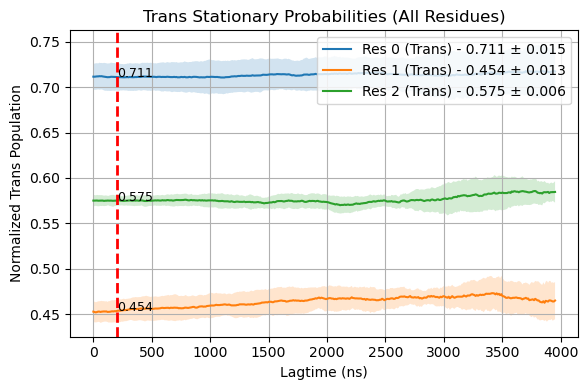

In [8]:
point_to_plot = 400
lagtime_plot = 24  # Index of lagtime to annotate

plt.figure(figsize=(6, 4))

for res_index in range(3):
    for state_index in range(1):
        res = hrex_cis_trans_pi_means[state_index, res_index]   # shape (604, 2)
        std = hrex_cis_trans_pi_stds[state_index, res_index]    # shape (604, 2)

        # Plot trans population
        plt.plot(
            hrex_lagtimes_ns[:point_to_plot], 
            res[:point_to_plot, 1], 
            label=f"Res {res_index} (Trans) - {res[lagtime_plot, 1]:.3f} ± {std[lagtime_plot, 1]:.3f}"
        )

        # Fill between ± std
        plt.fill_between(
            hrex_lagtimes_ns[:point_to_plot],
            res[:point_to_plot, 1] + std[:point_to_plot, 1],
            res[:point_to_plot, 1] - std[:point_to_plot, 1],
            alpha=0.2
        )

        # Annotate a specific lagtime point
        first_x = hrex_lagtimes_ns[lagtime_plot]
        first_y = res[lagtime_plot, 1]
        plt.text(first_x, first_y, f"{first_y:.3f}", fontsize=9)
        print(f"Res {res_index}, State {state_index}: {first_x:.2f} ns : {first_y:.3f}")

# Draw vertical annotation line only once
plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)

plt.title("Trans Stationary Probabilities (All Residues)")
plt.xlabel("Lagtime (ns)")
plt.ylabel("Normalized Trans Population")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## EE

In [9]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..11) back into a (2,) array [a, x], where:
      - a ∈ {0, 1}
      - x ∈ {0, 1, 2, 3}

    Inverse of:
        index = 4 * a + x

    Parameters
    ----------
    index : int or array-like of ints
        Integer(s) in the range [0, 11].

    Returns
    -------
    state : np.ndarray
        If input is a scalar, returns a (2,) array [a, x].
        If input is array-like, returns shape (..., 2).
    
    """
    index = np.asarray(index)

    if np.any((index < 0) | (index > 11)):
        raise ValueError(f"Index out of range: {index}. Expected values in 0..11.")

    a = index // 4
    x = index % 4

    return np.stack([a, x], axis=-1)


In [10]:
ee_path = '../EE/analysis'

omega_loaded = Data.load(f"{ee_path}/autocoorel_data/stationary_distributions_res.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_stds = omega_loaded[3]
ee_lagtimes_ns = omega_loaded[8]

pi_all_means[0]


array([[7.21362439e-02, 7.13772191e-02, 7.31119073e-02, ...,
        9.76141190e-06, 9.76141190e-06, 9.76141190e-06],
       [7.20767537e-02, 7.13127246e-02, 7.31718687e-02, ...,
        9.50198897e-06, 9.50198897e-06, 9.50198897e-06],
       [7.18912737e-02, 7.13269552e-02, 7.33379148e-02, ...,
        1.01439434e-05, 1.01439434e-05, 1.01439434e-05],
       ...,
       [8.72834799e-02, 8.51781666e-02, 8.29696936e-02, ...,
        7.07954495e-02, 7.07954495e-02, 7.07954495e-02],
       [8.67209936e-02, 8.59335773e-02, 8.45388170e-02, ...,
        7.59029384e-02, 7.59029384e-02, 7.59029384e-02],
       [8.52771418e-02, 8.49675710e-02, 8.36985328e-02, ...,
        7.59500590e-02, 7.59500590e-02, 7.59500590e-02]])

In [11]:
state_num = 4
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    
    cis_state = state + 0
    trans_state = state + state_num

    pi_means_state = pi_all_means[:, :, [cis_state, trans_state]]
    pi_stds_state = pi_all_stds[:, :, [cis_state, trans_state]]
    
    # Compute row sums
    row_sums = pi_means_state.sum(axis=2, keepdims=True)
    pi_means_state /= row_sums # Renormalize the mean 
    pi_stds_state /= row_sums # Renormalize the standard deviation

    # Print shapes to confirm correctness
    print(f"pi_means_state shape: {pi_means_state.shape}")  # Expected: (3, 604, 2)
    print(f"pi_stds_state shape: {pi_stds_state.shape}")  # Expected: (3, 604, 2)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means_state)
    cis_trans_pi_stds.append(pi_stds_state)

# Stack results into shape: (6, 3, 604, 2)
ee_cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
ee_cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("ee_cis_trans_pi_means shape:", ee_cis_trans_pi_means.shape)
print("ee_cis_trans_pi_stds shape:", ee_cis_trans_pi_stds.shape)


pi_means_state shape: (3, 184, 2)
pi_stds_state shape: (3, 184, 2)
pi_means_state shape: (3, 184, 2)
pi_stds_state shape: (3, 184, 2)
pi_means_state shape: (3, 184, 2)
pi_stds_state shape: (3, 184, 2)
pi_means_state shape: (3, 184, 2)
pi_stds_state shape: (3, 184, 2)
ee_cis_trans_pi_means shape: (4, 3, 184, 2)
ee_cis_trans_pi_stds shape: (4, 3, 184, 2)


Res 0, State 0: 101.00 ns : 0.705
Res 1, State 0: 101.00 ns : 0.466
Res 2, State 0: 101.00 ns : 0.598


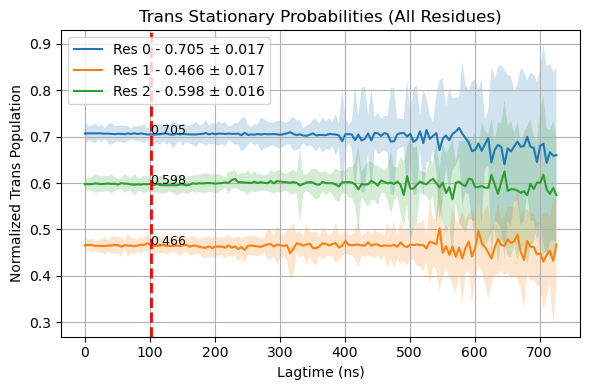

In [12]:
point_to_plot = 150
lagtime_plot = 24  # Index of lagtime to annotate

plt.figure(figsize=(6, 4))

for res_index in range(3):
    for state_index in range(1):
        res = ee_cis_trans_pi_means[state_index, res_index]   # shape (604, 2)
        std = ee_cis_trans_pi_stds[state_index, res_index]    # shape (604, 2)

        # Plot trans population
        plt.plot(
            ee_lagtimes_ns[:point_to_plot], 
            res[:point_to_plot, 1], 
            label=f"Res {res_index} - {res[lagtime_plot, 1]:.3f} ± {std[lagtime_plot, 1]:.3f}"
        )

        # Fill between ± std
        plt.fill_between(
            ee_lagtimes_ns[:point_to_plot],
            res[:point_to_plot, 1] + std[:point_to_plot, 1],
            res[:point_to_plot, 1] - std[:point_to_plot, 1],
            alpha=0.2
        )

        # Annotate a specific lagtime point
        first_x = ee_lagtimes_ns[lagtime_plot]
        first_y = res[lagtime_plot, 1]
        plt.text(first_x, first_y, f"{first_y:.3f}", fontsize=9)
        print(f"Res {res_index}, State {state_index}: {first_x:.2f} ns : {first_y:.3f}")

# Draw vertical line once
plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)

plt.title("Trans Stationary Probabilities (All Residues)")
plt.xlabel("Lagtime (ns)")
plt.ylabel("Normalized Trans Population")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## REDs

In [13]:
reds_path = '../REDs/analysis'

omega_loaded = Data.load(f"{reds_path}/autocoorel_data/stationary_distributions_res.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_stds = omega_loaded[3]
reds_lagtimes_ns = omega_loaded[8]

pi_all_means.shape


(3, 679, 6)

In [14]:
state_num = 3
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    
    cis_state = state + 0
    trans_state = state + state_num

    pi_means_state = pi_all_means[:, :, [cis_state, trans_state]]
    pi_stds_state = pi_all_stds[:, :, [cis_state, trans_state]]
    
    # Compute row sums
    row_sums = pi_means_state.sum(axis=2, keepdims=True)
    pi_means_state /= row_sums # Renormalize the mean 
    pi_stds_state /= row_sums # Renormalize the standard deviation

    # Print shapes to confirm correctness
    print(f"pi_means_state shape: {pi_means_state.shape}")  # Expected: (3, 604, 2)
    print(f"pi_stds_state shape: {pi_stds_state.shape}")  # Expected: (3, 604, 2)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means_state)
    cis_trans_pi_stds.append(pi_stds_state)

# Stack results into shape: (6, 3, 604, 2)
reds_cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
reds_cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("reds_cis_trans_pi_means shape:", reds_cis_trans_pi_means.shape)
print("reds_cis_trans_pi_stds shape:", reds_cis_trans_pi_stds.shape)


pi_means_state shape: (3, 679, 2)
pi_stds_state shape: (3, 679, 2)
pi_means_state shape: (3, 679, 2)
pi_stds_state shape: (3, 679, 2)
pi_means_state shape: (3, 679, 2)
pi_stds_state shape: (3, 679, 2)
reds_cis_trans_pi_means shape: (3, 3, 679, 2)
reds_cis_trans_pi_stds shape: (3, 3, 679, 2)


Res 0, State 0: 200.40 ns : 0.723
Res 1, State 0: 200.40 ns : 0.460
Res 2, State 0: 200.40 ns : 0.593


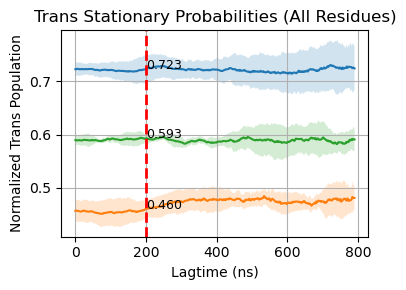

In [15]:
point_to_plot = 400
lagtime_plot = 104  # Index of lagtime to annotate
state_num = 1

plt.figure(figsize=(4, 3))  # Create one figure for all residues

for res_index in range(3):
    for state_index in range(state_num):
        res = reds_cis_trans_pi_means[state_index, res_index]   # shape (604, 2)
        std = reds_cis_trans_pi_stds[state_index, res_index]    # shape (604, 2)

        # Plot trans population
        plt.plot(
            reds_lagtimes_ns[:point_to_plot], 
            res[:point_to_plot, 1], 
            label=f"Res {res_index} (Trans) - {res[lagtime_plot, 1]:.3f} ± {std[lagtime_plot, 1]:.3f}"
        )

        # Fill between ± std
        plt.fill_between(
            reds_lagtimes_ns[:point_to_plot],
            res[:point_to_plot, 1] + std[:point_to_plot, 1],
            res[:point_to_plot, 1] - std[:point_to_plot, 1],
            alpha=0.2
        )

        # Annotate a specific lagtime point
        first_x = reds_lagtimes_ns[lagtime_plot]
        first_y = res[lagtime_plot, 1]
        plt.text(first_x, first_y, f"{first_y:.3f}", fontsize=9)
        print(f"Res {res_index}, State {state_index}: {first_x:.2f} ns : {first_y:.3f}")

# Draw vertical line once for lagtime_plot
plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)

plt.title("Trans Stationary Probabilities (All Residues)")
plt.xlabel("Lagtime (ns)")
plt.ylabel("Normalized Trans Population")
plt.grid(True)
#plt.legend()
plt.tight_layout()
plt.show()


## Combine Plot with log scale

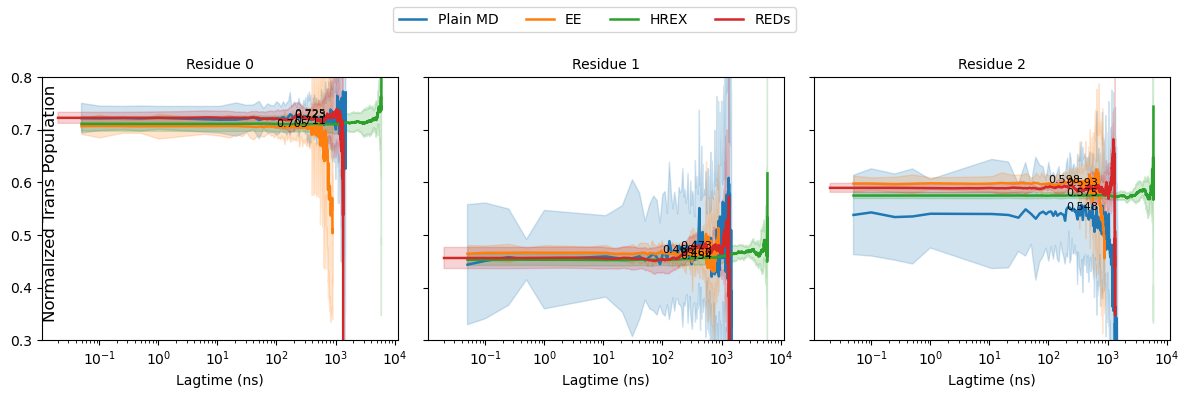

In [18]:
import matplotlib.pyplot as plt

# Method color map
method_colors = {
    'Plain MD': 'tab:blue',
    'EE': 'tab:orange',
    'HREX': 'tab:green',
    'REDs': 'tab:red'
}

# Control y-axis limit
y_lim = (0.3, 0.8)

# Define plotting info for all methods
methods = [
    {
        'name': 'Plain MD',
        'means': plain_md_pi_all_means,
        'stds': plain_md_pi_all_stds,
        'lagtimes': plain_md_lagtimes_ns,
        'lagtime_plot': 24
    },
    {
        'name': 'EE',
        'means': ee_cis_trans_pi_means,
        'stds': ee_cis_trans_pi_stds,
        'lagtimes': ee_lagtimes_ns,
        'lagtime_plot': 24
    },
    {
        'name': 'HREX',
        'means': hrex_cis_trans_pi_means,
        'stds': hrex_cis_trans_pi_stds,
        'lagtimes': hrex_lagtimes_ns,
        'lagtime_plot': 24
    },
    {
        'name': 'REDs',
        'means': reds_cis_trans_pi_means,
        'stds': reds_cis_trans_pi_stds,
        'lagtimes': reds_lagtimes_ns,
        'lagtime_plot': 104
    }
]

# Create 1x3 figure
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, res_index in enumerate(residues):
    ax = axs[i]

    for method in methods:
        name = method['name']
        lagtimes = method['lagtimes']
        lagtime_plot = method['lagtime_plot']

        if name == 'Plain MD':
            means = method['means'][res_index]
            stds = method['stds'][res_index]
        else:
            means = method['means'][0, res_index]
            stds = method['stds'][0, res_index]

        point_to_plot = len(lagtimes)

        ax.plot(
            lagtimes[:point_to_plot],
            means[:point_to_plot, 1],
            label=name,
            color=method_colors[name],
            linewidth=1.8
        )

        ax.fill_between(
            lagtimes[:point_to_plot],
            means[:point_to_plot, 1] + stds[:point_to_plot, 1],
            means[:point_to_plot, 1] - stds[:point_to_plot, 1],
            color=method_colors[name],
            alpha=0.2
        )

        # Annotate one point
        first_x = lagtimes[lagtime_plot]
        first_y = means[lagtime_plot, 1]
        ax.text(first_x, first_y, f"{first_y:.3f}", fontsize=8)

    ax.set_xscale('log')
    ax.set_ylim(y_lim)
    ax.set_xlabel('Lagtime (ns)')
    ax.set_title(f'Residue {res_index}', fontsize=10)
    # No grid
    ax.grid(False)

# Shared y label
fig.text(0.04, 0.5, 'Normalized Trans Population', va='center', rotation='vertical', fontsize=12)

# Global legend
handles = [plt.Line2D([0], [0], color=method_colors[name], linewidth=1.8, label=name) for name in method_colors]
fig.legend(handles=handles, loc='upper center', ncol=4, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.savefig(f"fig/stationary_population_all_res_log_scale.pdf", )
plt.show()


## Combine Plot

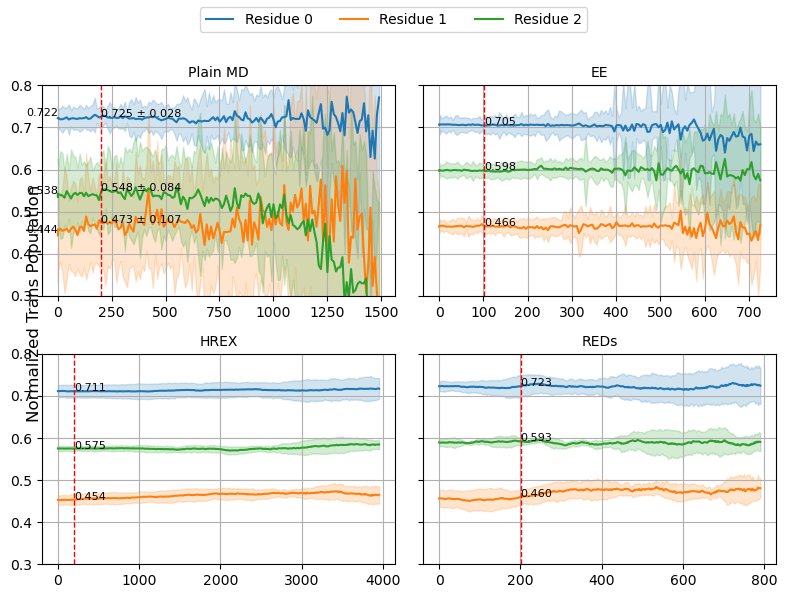

In [17]:
import matplotlib.pyplot as plt

# Define colors for residues
colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

# You can control y-limits here:
y_lim = (0.3, 0.8)  # set to None if you want auto

# Setup 2x2 subplots with shared y-axis only
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True)
axs = axs.flatten()

# Subplot 1 — Plain MD
ax = axs[0]
for res in residues:
    pi_means = plain_md_pi_all_means[res]
    pi_stds = plain_md_pi_all_stds[res] 

    ax.plot(plain_md_lagtimes_ns, pi_means[:, 1], '-', color=colors[res], linewidth=1.5)
    ax.fill_between(plain_md_lagtimes_ns, pi_means[:, 1] + pi_stds[:, 1], pi_means[:, 1] - pi_stds[:, 1], 
                    color=colors[res], alpha=0.2)

    first_x0 = plain_md_lagtimes_ns[0]
    first_y0 = pi_means[0, 1]
    ax.text(first_x0, first_y0, f"{first_y0:.3f}", fontsize=8, ha='right', va='bottom')

    first_x = plain_md_lagtimes_ns[24]
    first_y = pi_means[24, 1]
    first_y_var = pi_stds[24, 1]
    ax.text(first_x, first_y,  f"{first_y:.3f} ± {first_y_var:.3f}", fontsize=8)

ax.axvline(x=first_x, color='r', linestyle='--', linewidth=1)
if y_lim:
    ax.set_ylim(y_lim)
ax.set_title("Plain MD", fontsize=10)
ax.grid(True)

# Subplot 2 — EE
ax = axs[1]
point_to_plot = 150
lagtime_plot = 24
for res_index in range(3):
    res = ee_cis_trans_pi_means[0, res_index]
    std = ee_cis_trans_pi_stds[0, res_index]

    ax.plot(ee_lagtimes_ns[:point_to_plot], res[:point_to_plot, 1], '-', color=colors[res_index], linewidth=1.5)
    ax.fill_between(ee_lagtimes_ns[:point_to_plot], 
                    res[:point_to_plot, 1] + std[:point_to_plot, 1], 
                    res[:point_to_plot, 1] - std[:point_to_plot, 1], 
                    color=colors[res_index], alpha=0.2)

    first_x = ee_lagtimes_ns[lagtime_plot]
    first_y = res[lagtime_plot, 1]
    ax.text(first_x, first_y, f"{first_y:.3f}", fontsize=8)

ax.axvline(x=first_x, color='r', linestyle='--', linewidth=1)
if y_lim:
    ax.set_ylim(y_lim)
ax.set_title("EE", fontsize=10)
ax.grid(True)

# Subplot 3 — HREX
ax = axs[2]
point_to_plot = 400
lagtime_plot = 24
for res_index in range(3):
    res = hrex_cis_trans_pi_means[0, res_index]
    std = hrex_cis_trans_pi_stds[0, res_index]

    ax.plot(hrex_lagtimes_ns[:point_to_plot], res[:point_to_plot, 1], '-', color=colors[res_index], linewidth=1.5)
    ax.fill_between(hrex_lagtimes_ns[:point_to_plot], 
                    res[:point_to_plot, 1] + std[:point_to_plot, 1], 
                    res[:point_to_plot, 1] - std[:point_to_plot, 1], 
                    color=colors[res_index], alpha=0.2)

    first_x = hrex_lagtimes_ns[lagtime_plot]
    first_y = res[lagtime_plot, 1]
    ax.text(first_x, first_y, f"{first_y:.3f}", fontsize=8)

ax.axvline(x=first_x, color='r', linestyle='--', linewidth=1)
if y_lim:
    ax.set_ylim(y_lim)
ax.set_title("HREX", fontsize=10)
ax.grid(True)

# Subplot 4 — REDs
ax = axs[3]
point_to_plot = 400
lagtime_plot = 104
for res_index in range(3):
    res = reds_cis_trans_pi_means[0, res_index]
    std = reds_cis_trans_pi_stds[0, res_index]

    ax.plot(reds_lagtimes_ns[:point_to_plot], res[:point_to_plot, 1], '-', color=colors[res_index], linewidth=1.5)
    ax.fill_between(reds_lagtimes_ns[:point_to_plot], 
                    res[:point_to_plot, 1] + std[:point_to_plot, 1], 
                    res[:point_to_plot, 1] - std[:point_to_plot, 1], 
                    color=colors[res_index], alpha=0.2)

    first_x = reds_lagtimes_ns[lagtime_plot]
    first_y = res[lagtime_plot, 1]
    ax.text(first_x, first_y, f"{first_y:.3f}", fontsize=8)

ax.axvline(x=first_x, color='r', linestyle='--', linewidth=1)
if y_lim:
    ax.set_ylim(y_lim)
ax.set_title("REDs", fontsize=10)
ax.grid(True)

# Shared y-label
fig.text(0.04, 0.5, 'Normalized Trans Population', va='center', rotation='vertical', fontsize=12)

# Global legend
handles = [plt.Line2D([0], [0], color=colors[res], linestyle='-', linewidth=1.5, label=f"Residue {res}") for res in residues]
fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig(f"fig/stationary_population_all_res.pdf")
plt.show()
